## NHL Season Outcome Multiple Linear Regression

### Description

The following regression analysis seeks to predict team season adjusted wins **(wins + (ties / 2))** deviation for years 1983 - 2021.

In [3]:
# Import libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from regressors import stats as stat
from pickle import dump
from pickle import load

from scipy.stats.mstats import normaltest
from scipy import stats

from Preprocessing_Functions import *
from Regression_Metrics_Functions import *

### Feature Selection and Data Preprocessing

In [4]:
# Import the data frame from the multiple regression EDA
nhl_df = pd.read_csv('Data/NHL_1983_2021_Perprocessed_Season_Data_Removed_Outliers.csv')

print('\n')
nhl_df.info()
nhl_df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   goals_per_game           922 non-null    float64
 1   goals_against_per_game   922 non-null    float64
 2   power_play_percentage    922 non-null    float64
 3   penalty_kill_percentage  922 non-null    float64
 4   shots_per_game           922 non-null    float64
 5   shots_allowed            922 non-null    float64
 6   shooting_pctg            922 non-null    float64
 7   save_pctg                922 non-null    float64
 8   failed_shots_per_game    922 non-null    float64
 9   saves_per_game           922 non-null    float64
 10  ties                     922 non-null    int64  
 11  power_play_efficiency    922 non-null    float64
 12  seaonsAdjWinsDev         922 non-null    float64
dtypes: float64(12), int64(1)
memory usage: 93.8 KB


,goals_per_game,goals_against_per_game,power_play_percentage,penalty_kill_percentage,shots_per_game,shots_allowed,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,seaonsAdjWinsDev
0,2.888,4.375,14.3,75.3,26.3875,32.0000,10.9,86.3,23.511263,27.616000,7,-0.085399,-19.470588
1,4.463,3.363,22.5,81.5,30.2750,33.3875,14.7,89.9,25.824575,30.015362,4,-0.010714,12.029412
2,3.925,3.800,25.1,78.1,31.8875,31.5500,12.3,88.0,27.965338,27.764000,9,-0.006780,6.529412
3,4.375,3.625,20.2,76.6,36.7500,28.6500,11.9,87.3,32.376750,25.011450,10,-0.066246,9.029412
4,3.175,4.875,20.9,76.0,28.3375,36.3500,11.2,86.6,25.163700,31.479100,6,-0.044248,-20.970588


The data from the regression EDA analysis is imported.

In [5]:
# Create a y and X data frames
y = nhl_df[nhl_df.columns[len(nhl_df.columns)-1:]].reset_index(drop = True)
X = nhl_df[nhl_df.columns[0:len(nhl_df.columns)-1]].reset_index(drop = True)

# Split y and X data frames into an 80/20 train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Concatenate X and y data for both train and test data
train_set_df = pd.concat([X_train.reset_index(drop = True), y_train.reset_index(drop = True)], axis = 1)
test_set_df = pd.concat([X_test.reset_index(drop = True), y_test.reset_index(drop = True)], axis = 1)

print('\n','<------------------------------------ Train Data ------------------------------------>'.center(110),'\n')
print(train_set_df.info())
display(train_set_df.head())
print('\n','<------------------------------------ Test Data ------------------------------------>'.center(110),'\n')
print(test_set_df.info())
display(test_set_df.head())


             <------------------------------------ Train Data ------------------------------------>             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   goals_per_game           645 non-null    float64
 1   goals_against_per_game   645 non-null    float64
 2   power_play_percentage    645 non-null    float64
 3   penalty_kill_percentage  645 non-null    float64
 4   shots_per_game           645 non-null    float64
 5   shots_allowed            645 non-null    float64
 6   shooting_pctg            645 non-null    float64
 7   save_pctg                645 non-null    float64
 8   failed_shots_per_game    645 non-null    float64
 9   saves_per_game           645 non-null    float64
 10  ties                     645 non-null    int64  
 11  power_play_efficiency    645 non-null    float64
 12  seaonsAdjWinsDev   

,goals_per_game,goals_against_per_game,power_play_percentage,penalty_kill_percentage,shots_per_game,shots_allowed,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,seaonsAdjWinsDev
0,2.512,2.354,17.7,85.2,28.7073,28.4390,8.8,91.7,26.181058,26.078563,9,0.068120,7.482143
1,2.292,2.542,15.3,81.1,28.3750,23.1250,8.1,89.0,26.076625,20.581250,10,-0.028409,-2.741379
2,2.841,2.573,18.5,83.8,31.5366,28.4024,9.0,90.9,28.698306,25.817782,10,0.024631,0.982143
3,2.561,3.000,12.9,83.9,26.3415,26.7073,9.7,88.8,23.786375,23.716082,13,-0.034591,-7.928571
4,2.671,3.024,17.1,81.1,29.6707,31.6707,9.0,90.5,27.000337,28.661984,11,-0.019920,-4.870968



             <------------------------------------ Test Data ------------------------------------>              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   goals_per_game           277 non-null    float64
 1   goals_against_per_game   277 non-null    float64
 2   power_play_percentage    277 non-null    float64
 3   penalty_kill_percentage  277 non-null    float64
 4   shots_per_game           277 non-null    float64
 5   shots_allowed            277 non-null    float64
 6   shooting_pctg            277 non-null    float64
 7   save_pctg                277 non-null    float64
 8   failed_shots_per_game    277 non-null    float64
 9   saves_per_game           277 non-null    float64
 10  ties                     277 non-null    int64  
 11  power_play_efficiency    277 non-null    float64
 12  seaonsAdjWinsDev   

,goals_per_game,goals_against_per_game,power_play_percentage,penalty_kill_percentage,shots_per_game,shots_allowed,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,ties,power_play_efficiency,seaonsAdjWinsDev
0,2.939,2.878,15.6,82.5,26.0610,28.7317,11.3,90.0,23.116107,25.858530,14,-0.005780,0.134615
1,2.963,2.537,16.6,84.4,30.1098,25.9268,9.8,90.2,27.159040,23.385974,16,0.021148,3.571429
2,2.415,3.341,16.9,79.8,28.9268,33.5488,8.3,90.0,26.525876,30.193920,9,-0.059375,-15.696429
3,2.244,2.549,14.5,87.2,27.6707,26.9146,8.1,90.5,25.429373,24.357713,11,0.017442,-3.346154
4,2.402,2.244,16.6,83.1,27.3293,28.0488,8.8,92.0,24.924322,25.804896,8,-0.024931,5.053571


To prevent over-fitting, the data is split into an 70/30 train and test split and feature selection will take place and be determined by the train set and then applied to the test set. <br>

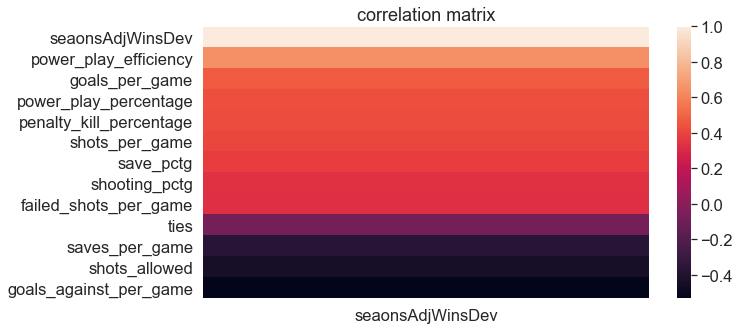

,seaonsAdjWinsDev
seaonsAdjWinsDev,1.000000
power_play_efficiency,0.642502
goals_per_game,0.467503
power_play_percentage,0.431564
penalty_kill_percentage,0.428970
shots_per_game,0.412147
save_pctg,0.378087
shooting_pctg,0.338047
failed_shots_per_game,0.332761
ties,-0.076520



features to remove: 
['ties']


In [6]:
# Analyze correlation of all X features with target variables (seaonsAdjWinsDev) on train data
X_num = train_set_df.select_dtypes(include = ['float64', 'int64'])

num_bivariate_corr_target(
    df = X_num, 
    target = 'seaonsAdjWinsDev', 
    threshold = 0.20, 
    font = 1.5,
    length = 5,
    width = 10
)

In [7]:
# Remove ties feature from both train and test data
train_set_df = train_set_df.drop(['ties'], axis =1)
test_set_df = test_set_df.drop(['ties'], axis =1)

The ties feature is removed from train and test data because it lacks a strong correlation defined by a threshold of at least 0.20 with seaonsAdjWinsDev.

In [8]:
# Removes features one by one to measure their VIF scores for threshold of 3.5 
vif_df = train_set_df.copy()
col_length = len(vif_df.columns)

vif = calculate_vif(
    X = vif_df, 
    target = 'seaonsAdjWinsDev',
    threshold = 5, 
    feature_elim = col_length
)

vif

,vif,features
0,7504.999872,Intercept
1,2.655439,save_pctg
2,2.504134,shooting_pctg
3,2.119605,penalty_kill_percentage
4,1.919467,power_play_percentage
5,1.371286,saves_per_game
6,1.301227,failed_shots_per_game



dropped features: 


[['shots_allowed',
  'shots_per_game',
  'goals_per_game',
  'goals_against_per_game',
  'power_play_efficiency'],
 [94279.96231843535,
  71805.02873250506,
  225.29614273900688,
  164.92385964700864,
  6.0855468472086285]]

In [9]:
# Observe independant variable correlations to create or bucket broader variables
corr = train_set_df.corr()

corr.style.background_gradient(cmap = 'coolwarm').set_precision(2)

,goals_per_game,goals_against_per_game,power_play_percentage,penalty_kill_percentage,shots_per_game,shots_allowed,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game,power_play_efficiency,seaonsAdjWinsDev
goals_per_game,1.00,0.44,0.64,-0.20,0.49,0.08,0.91,-0.49,0.28,-0.02,0.30,0.47
goals_against_per_game,0.44,1.00,0.15,-0.69,0.03,0.56,0.49,-0.87,-0.08,0.39,-0.42,-0.53
power_play_percentage,0.64,0.15,1.00,-0.15,0.42,0.09,0.53,-0.13,0.29,0.07,0.59,0.43
penalty_kill_percentage,-0.20,-0.69,-0.15,1.00,-0.10,-0.44,-0.19,0.57,-0.06,-0.34,0.59,0.43
shots_per_game,0.49,0.03,0.42,-0.10,1.00,-0.04,0.08,-0.07,0.97,-0.05,0.26,0.41
shots_allowed,0.08,0.56,0.09,-0.44,-0.04,1.00,0.11,-0.09,-0.06,0.98,-0.34,-0.44
shooting_pctg,0.91,0.49,0.53,-0.19,0.08,0.11,1.00,-0.53,-0.15,0.01,0.23,0.34
save_pctg,-0.49,-0.87,-0.13,0.57,-0.07,-0.09,-0.53,1.00,0.05,0.10,0.30,0.38
failed_shots_per_game,0.28,-0.08,0.29,-0.06,0.97,-0.06,-0.15,0.05,1.00,-0.05,0.21,0.33
saves_per_game,-0.02,0.39,0.07,-0.34,-0.05,0.98,0.01,0.10,-0.05,1.00,-0.28,-0.37


Eliminating features one by one to measure their variance inflation factors (VIF). Features with VIF scores of greater than 3.5 are removed. This will help in eliminating multicollinear features.

Removed features (removed in the order displayed below):

1) **shots_allowed** - VIF > 5 <br><br>
2) **shots_per_game** - VIF > 5<br><br>
3) **goals_per_game** - VIF > 5<br><br>
4) **goals_against_per_game** - VIF > 5<br><br>
5) **power_play_efficiency** - VIF > 5<br><br>

We can further explore the Pearson correlations between the variables to be eliminated with the greater set of variables to be kept. 

In [10]:
print('\n','<------------------------------------ Train Data ------------------------------------>'.center(110),'\n')
# Remove list of features from train data to accomodate VIF score threshold
train_set_df = train_set_df.drop(vif[0] + ['power_play_percentage'], axis = 1, errors = 'ignore')
X_train_df = train_set_df[train_set_df.columns[0:-1]]
y_train_df = train_set_df[['seaonsAdjWinsDev']]

print(X_train_df.info())
display(X_train_df.head())
print('\n')
print(y_train_df.info())
display(y_train_df.head())

print('\n','<------------------------------------ Test Data ------------------------------------>'.center(110),'\n')
# Remove list of features from test data to accomodate VIF score threshold
test_set_df = test_set_df.drop(vif[0] + ['power_play_percentage'], axis = 1, errors = 'ignore')
X_test_df = test_set_df[test_set_df.columns[0:-1]]
y_test_df = test_set_df[['seaonsAdjWinsDev']]
 
print(X_test_df.info())
display(X_test_df.head())
print('\n')
print(y_test_df.info())
display(y_test_df.head())


             <------------------------------------ Train Data ------------------------------------>             

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   penalty_kill_percentage  645 non-null    float64
 1   shooting_pctg            645 non-null    float64
 2   save_pctg                645 non-null    float64
 3   failed_shots_per_game    645 non-null    float64
 4   saves_per_game           645 non-null    float64
dtypes: float64(5)
memory usage: 25.3 KB
None


,penalty_kill_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game
0,85.2,8.8,91.7,26.181058,26.078563
1,81.1,8.1,89.0,26.076625,20.581250
2,83.8,9.0,90.9,28.698306,25.817782
3,83.9,9.7,88.8,23.786375,23.716082
4,81.1,9.0,90.5,27.000337,28.661984




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seaonsAdjWinsDev  645 non-null    float64
dtypes: float64(1)
memory usage: 5.2 KB
None


,seaonsAdjWinsDev
0,7.482143
1,-2.741379
2,0.982143
3,-7.928571
4,-4.870968



             <------------------------------------ Test Data ------------------------------------>              

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   penalty_kill_percentage  277 non-null    float64
 1   shooting_pctg            277 non-null    float64
 2   save_pctg                277 non-null    float64
 3   failed_shots_per_game    277 non-null    float64
 4   saves_per_game           277 non-null    float64
dtypes: float64(5)
memory usage: 10.9 KB
None


,penalty_kill_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game
0,82.5,11.3,90.0,23.116107,25.858530
1,84.4,9.8,90.2,27.159040,23.385974
2,79.8,8.3,90.0,26.525876,30.193920
3,87.2,8.1,90.5,25.429373,24.357713
4,83.1,8.8,92.0,24.924322,25.804896




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seaonsAdjWinsDev  277 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB
None


,seaonsAdjWinsDev
0,0.134615
1,3.571429
2,-15.696429
3,-3.346154
4,5.053571


The features with VIF scores greater then five are removed from the train and test data. Additionally after running the regression with all features included, power_play_percentage was not significant at p > 0.05 and was also removed from the data set.

### Model Training and Testing

#### Model Training, Evaluation, and Interpretation  

In [11]:
k_fold = ShuffleSplit(
    n_splits = 10, 
    random_state = 0, 
    test_size = 0.20, 
    train_size = None
)

print('\n' + 'Train and Test Shuffled K-Fold Data:' + '\n')
for train_index, test_index in k_fold.split(X_train_df):
    print("train index:", train_index[:10], "length:", len(train_index))
    print("test index:", test_index[:10], "length:", len(test_index))
    print('')


Train and Test Shuffled K-Fold Data:

train index: [581 632 263 222 142 416  12 334 350 337] length: 516
test index: [352 530 315 249 266 639 242 294 465 240] length: 129

train index: [ 66 444   1 589 512 461 322 224 424  58] length: 516
test index: [578 610 569 516 198 104  31 373 350  46] length: 129

train index: [399 333  53 641 531 294 546  80 228 274] length: 516
test index: [ 44 182 314 259 365  37 593 491 163 132] length: 129

train index: [334 258  15 311 372 308 289 115 373 325] length: 516
test index: [447 538 217 474 554  60 121 592 337 174] length: 129

train index: [579 424 170 498 445 114 405  38  93 560] length: 516
test index: [452 176 461 480 298 594 521 275 547 473] length: 129

train index: [210  74 463 412 640 426 424 375  88 274] length: 516
test index: [ 59  13 183 344 374 217 395 545 429 285] length: 129

train index: [395 102 584  98  79 225 143 199 346  28] length: 516
test index: [520   0  68 247 171 234 259  18 237 394] length: 129

train index: [544 182 3

The above displays the data for the shuffled k-fold data to be used in the cross validation process.

The f-fold test data has a specified size of 20% of the total train data.


test model f-fold metrics:



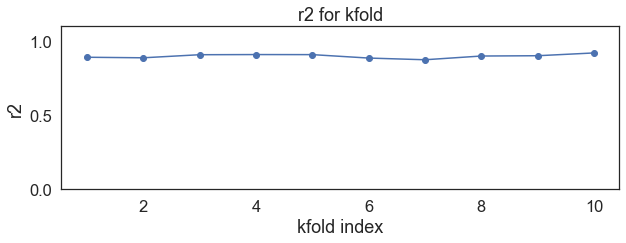

r-squared k-fold cross validation:                 .................0.9
r-squared std:                                     ................0.01


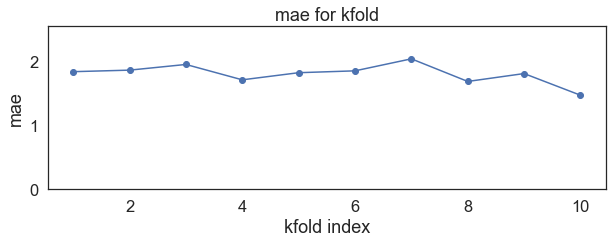



mean absolute error k-fold cross validation:       .................1.8
mean absolute error std:                           ................0.16


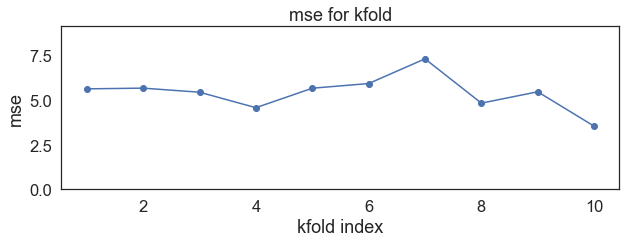



mean squared error k-fold cross validation:        ................5.39
mean squared error std:                            ................0.98


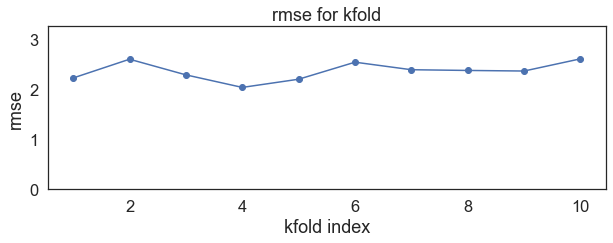



root mean squared error k-fold cross validation:   ................2.37
root mean squared error std:                       ................0.18




In [12]:
# K-fold cross validation regression evaluation metrics for train data
regression_cross_val_shuffle(
    regressor = LinearRegression(), 
    X_train = X_train_df, 
    y_train = y_train_df, 
    cv = k_fold, 
    font = 1.5
)

Above are the k-fold cross validation results.

The model performance appears to deliver strong and consistent results on the train data. 

In [13]:
# Convert data frames to numpy arrays
X_train = X_train_df.iloc[:,:].values

y_train = y_train_df.iloc[:,:].values
y_train = y_train.reshape((-1,))

X_test = X_test_df.iloc[:,:].values
y_test = y_test_df.iloc[:,:].values
y_test = y_test.reshape((-1,))

# Fit and train model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict with X_train data
y_pred_train = regressor.predict(X_train)
# Create data frame with predicted results for train data
y_pred_train_df = pd.DataFrame(y_pred_train, columns = ['predictions_train']).reset_index()

# Create a single data frame with all prediction and actual y data for train data
y_train_df = pd.DataFrame(y_train, columns = ['seaonsAdjWinsDev']).reset_index()
pred_train_df = pd.merge(y_pred_train_df, y_train_df, on = 'index')
y_pred_train_df = y_pred_train_df.drop(['index'], axis = 1, errors = 'ignore')
y_train_df = y_train_df.drop(['index'], axis = 1, errors = 'ignore')
pred_train_df['residuals_train'] = pred_train_df['predictions_train'] - pred_train_df['seaonsAdjWinsDev']

print('\n')
pred_train_df.info()
display(pred_train_df.head())

print('\n')
Xlabels = X_train_df.columns
stat.summary(regressor, X_train, y_train, Xlabels)

# ANOVA for F-stat
k = len(X_train_df.columns)
n = y_train_df.size

F = stat.f_stat(regressor, X_train, y_train)

dfn = k 
dfd = n - k 

F_p_value = round(1 - stats.f.cdf(F, dfn, dfd), 0)

print('\n' + 'F-satististic p-value: ' + str(F_p_value))



<class 'pandas.core.frame.DataFrame'>
Int64Index: 645 entries, 0 to 644
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              645 non-null    int64  
 1   predictions_train  645 non-null    float64
 2   seaonsAdjWinsDev   645 non-null    float64
 3   residuals_train    645 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 25.2 KB


,index,predictions_train,seaonsAdjWinsDev,residuals_train
0,0,1.950099,7.482143,-5.532044
1,1,-4.717519,-2.741379,-1.976140
2,2,3.265762,0.982143,2.283619
3,3,-6.929194,-7.928571,0.999378
4,4,-4.757618,-4.870968,0.113350




Residuals:
    Min      1Q  Median     3Q    Max
-8.6294 -1.4705 -0.0455 1.4673 8.9492


Coefficients:
                           Estimate  Std. Error   t value   p value
_intercept              -430.136755    7.580142  -56.7452  0.000000
penalty_kill_percentage   -0.078828    0.028054   -2.8099  0.005107
shooting_pctg              4.133221    0.058707   70.4043  0.000000
save_pctg                  4.399138    0.035016  125.6325  0.000000
failed_shots_per_game      1.399133    0.044485   31.4518  0.000000
saves_per_game            -1.441837    0.042537  -33.8964  0.000000
---
R-squared:  0.89649,    Adjusted R-squared:  0.89568
F-statistic: 1106.86 on 5 features

F-satististic p-value: 0.0


The above is a data frame focusing on the train model results.

The model shows strong results on the train data.  

Additionally, the adj-r2 is virtually similar to r2 (0.0008 difference), showing the impact of the multiple features included in the model.

Further, the regression model is determined to be significant at p < 0.05 (**Prob (F-statistic: 1106.86): 0.0**). This reveals that the regression model explains the adjusted wins deviation and target variable well and not by random chance.

All predictors' coefficients are significant at p < 0.05. The impact of the predictors is as follows:

1) **penalty_kill_percentage** - Intuitively, being on the penalty kill, regardless of success or not, is a total negative to the overall yearly results as seen by the decrease in seaonsAdjWinsDev as penaltyKillPercentage increases<br><br>

2) **shooting_pctg** - Intuitively, as the percent of shots leading to goals increases, the seaonsAdjWinsDev also increases. This outcome can be perceived as, among many other factors, offensive efficiency, strategy efficiency, more offensive skill, physically in shape team, creating impactful shot attempts, etc. <br><br>

3) **save_pctg** - Intuitively, as save percentage increases, the seaonsAdjWinsDev also increases. This outcome can be perceived as goaltending skill, efficient defensive strategy, defensive skill, physically in shape team, forcing bad shots attempts, etc. <br><br>

4) **saves_per_game** - As saves per game increases, the seaonsAdjWinsDev decreases. This outcome can be perceived as more work the goaltender outputs, more time players spend defending, less time in the offensive zone, lacking offensive and defensive strategy, lack of offensive and defensive skill, the pace being set by the opposing team, physically out of shape team, etc. <br><br>

5) **failed_shots_per_game** - As shot attempts increase, the seaonsAdjWinsDev also increases. This outcome can be perceived as spending more time in the offensive zone, less time in the defensive zone, offensive and defensive skill, setting the pace of the game, putting a heavy workload on the opposing team, better offensive and defensive strategy, physically in shape team, etc. <br><br>

**Note** The features are not scaled and therefore not to be compared against each other.

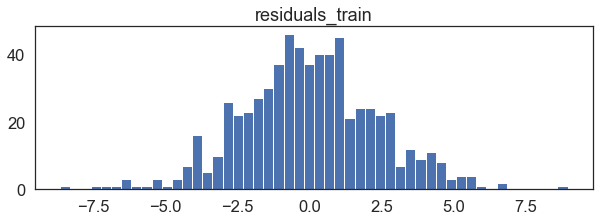


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
residuals_train,645.0,8.674405e-14,2.356409,-8.629449,-1.470524,-0.045529,1.467306,8.949178



normality test:

statistic: 0.07
p-value: 5.24



In [13]:
# residuals_train distribution
wins = pred_train_df.copy()
wins = pred_train_df[['residuals_train']]

num_univariate_histogram(
    df = wins, 
    length = 3, 
    width = 10, 
    rows = 1, 
    col = 1, 
    font = 1.5, 
    kind = 2
)

print(
    '\n' + 'normality test:' +  '\n' + '\n' + 'statistic: ' + str(round(normaltest(wins.residuals_train.values)[1], 2)) +
    '\n' + 'p-value: ' + str(round(normaltest(wins.residuals_train.values)[0],2)) + '\n'
)

The residuals are normally distributed as shown by the large p-value > 0.05. 

The residuals' mean is 0 indicating that the errors are close to 0.

The distribution also displays some outliers on the left and right tails roughly beyond -7.5 and 7.5.

The outliers show the models under and over prediction of seaonsAdjWinsDev.

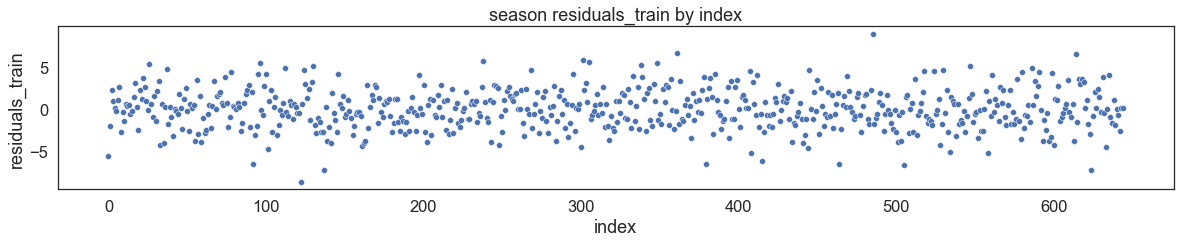

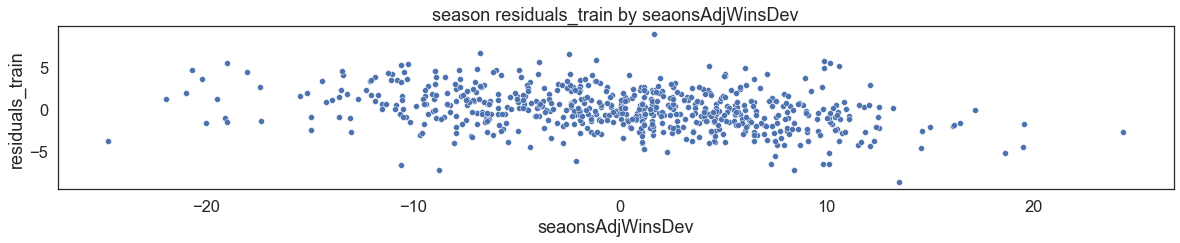

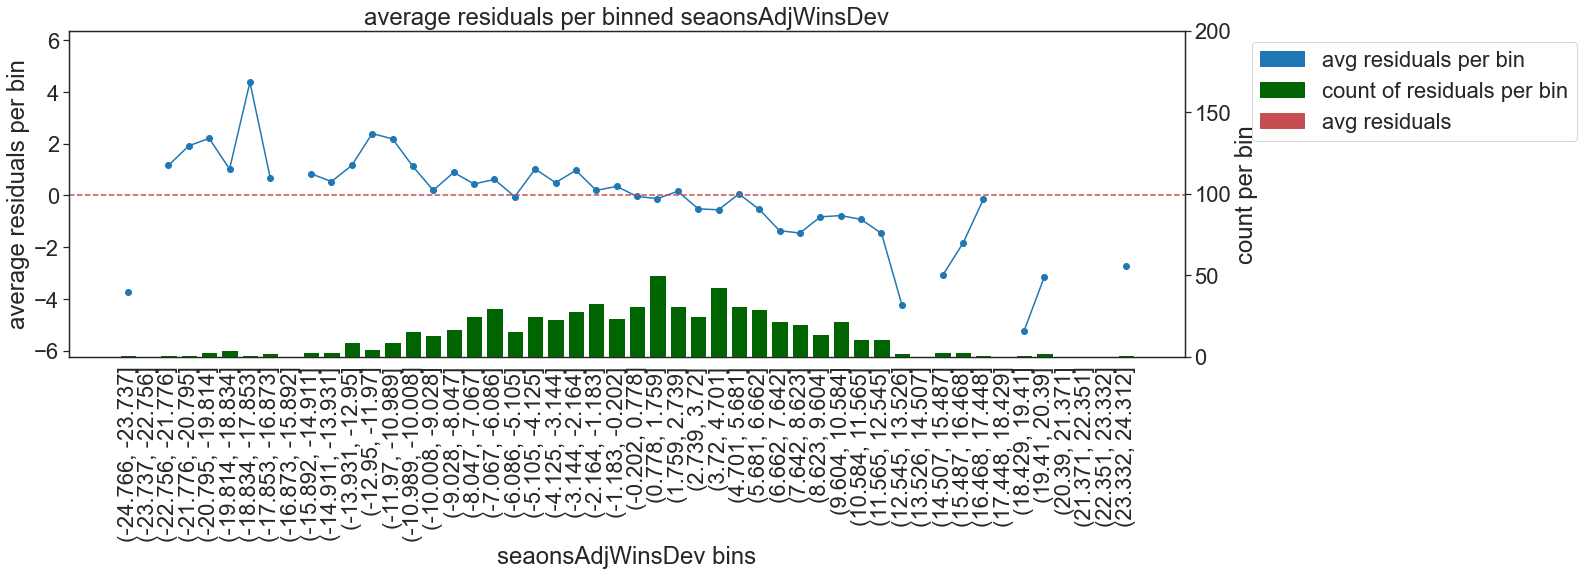

In [14]:
# residuals_train by index scatter plot
target_univariate_scatter(
    df = pred_train_df, 
    x = 'index', 
    y = 'residuals_train',
    length = 3, 
    width = 20,
    font = 1.5
)

# residuals_train by seaonsAdjWinsDev scatter plot
target_univariate_scatter(
    df = pred_train_df,
    x = 'seaonsAdjWinsDev',
    y = 'residuals_train',
    length = 3,
    width = 20, 
    font = 1.5
)

# Residual means and counts plot
residual_means_counts_plot(
    df = pred_train_df, 
    X = 'seaonsAdjWinsDev', 
    res = 'residuals_train',
    ymin1 = -1, 
    ymax1 = 2, 
    ymin2 = 0,
    ymax2 = 150, 
    font = 2, 
    length = 6, 
    width = 20
)

The residuals appear to be randomly distributed, as shown by the seaonsAdjWinsDev index scatter plot above.

The model also appears to over-predict where the seaonsAdjWinsDev are low and under-predict where the seaonsAdjWinsDev are high.

The over and under predictions can be found at the tail ends of seaonsAdjWinsDev target variable distribution (outliers). 

Overall, the residuals are not overwhelmingly high.

**Note** - the empty spaces in the line plot are NA values.

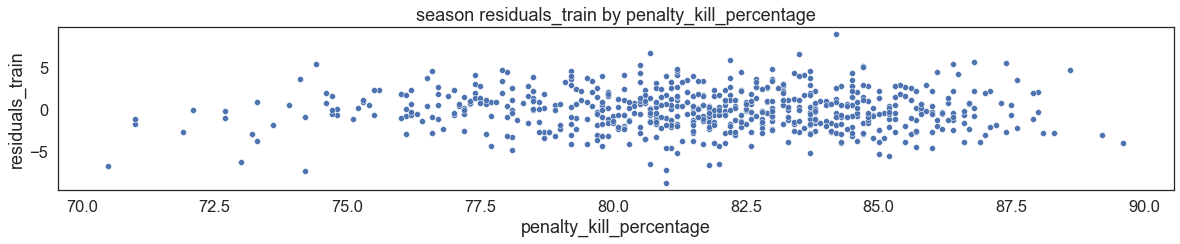

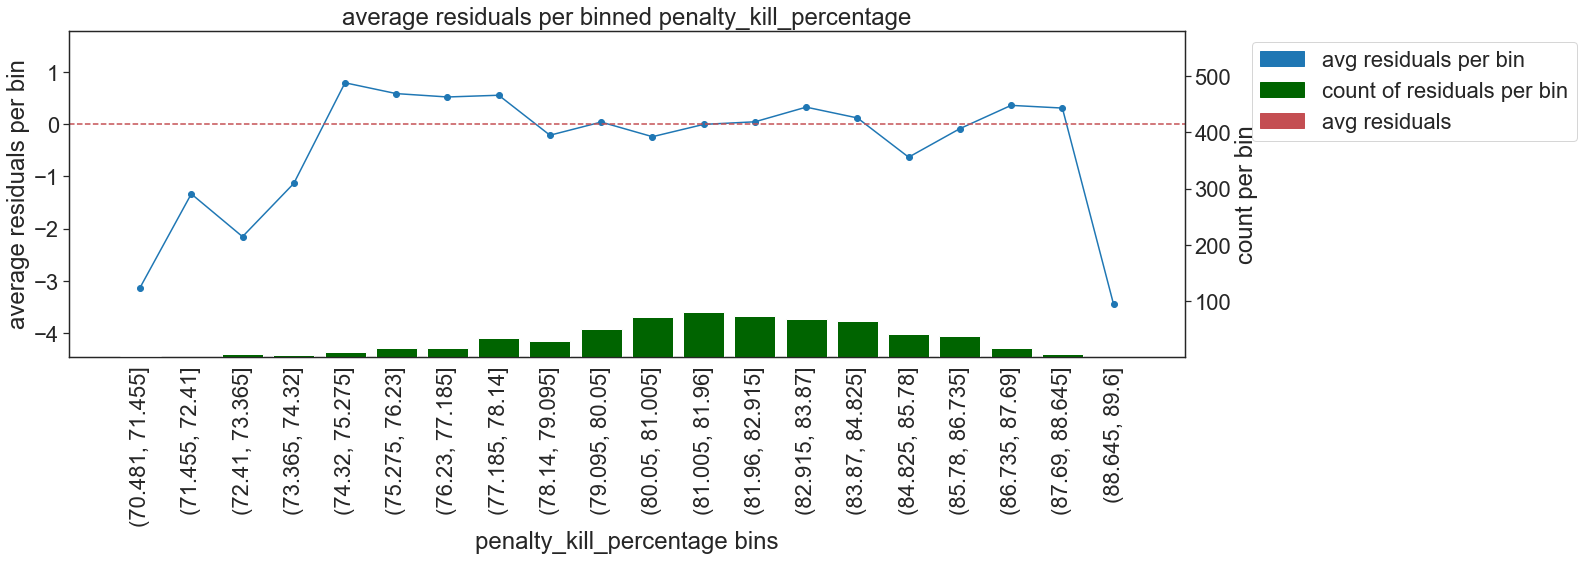

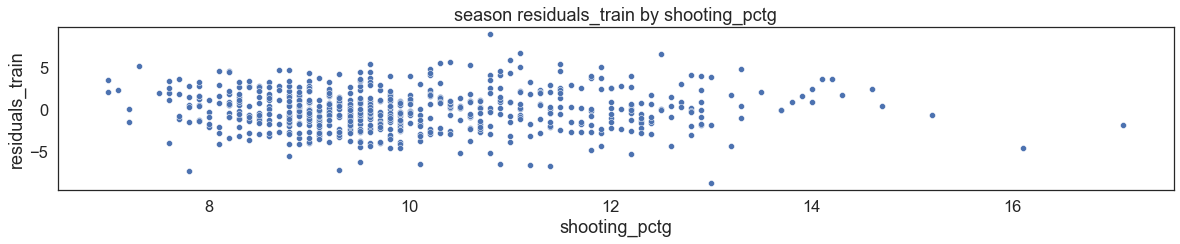

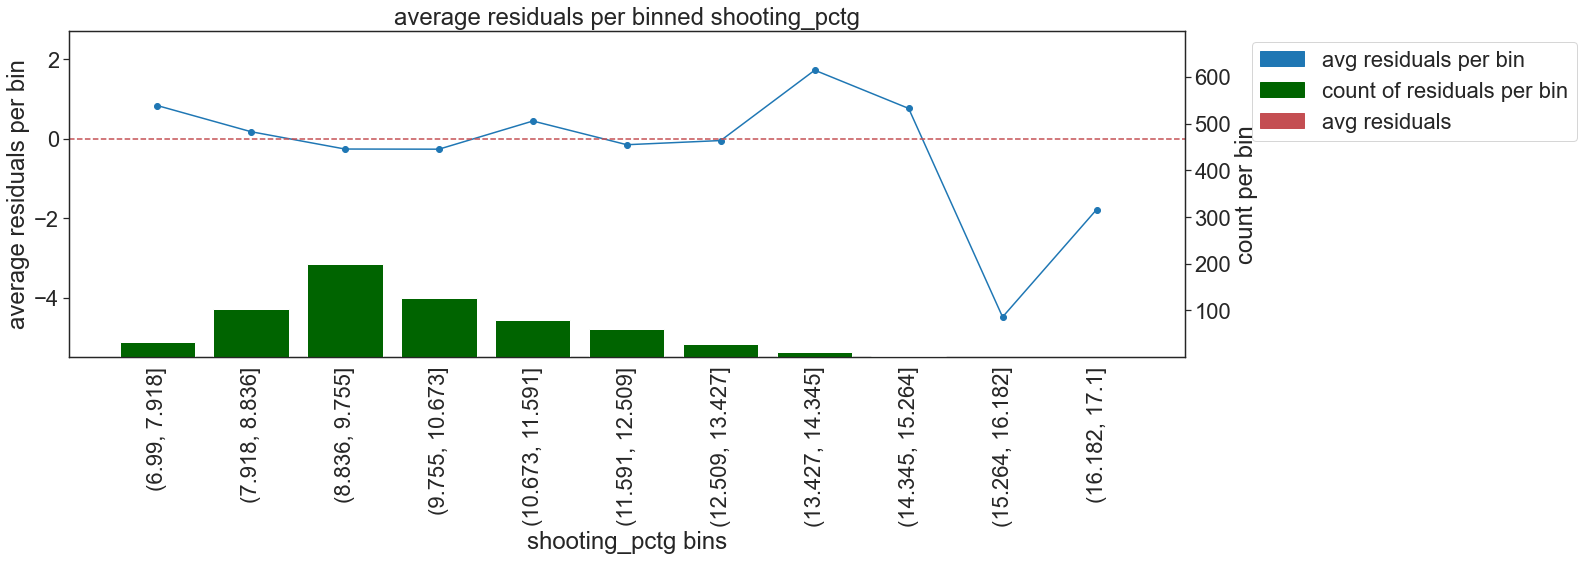

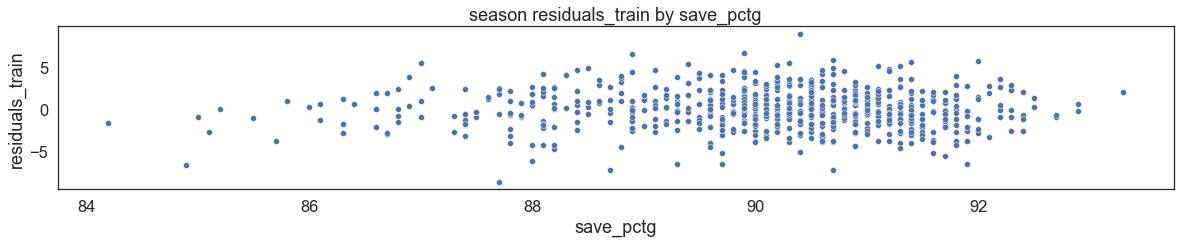

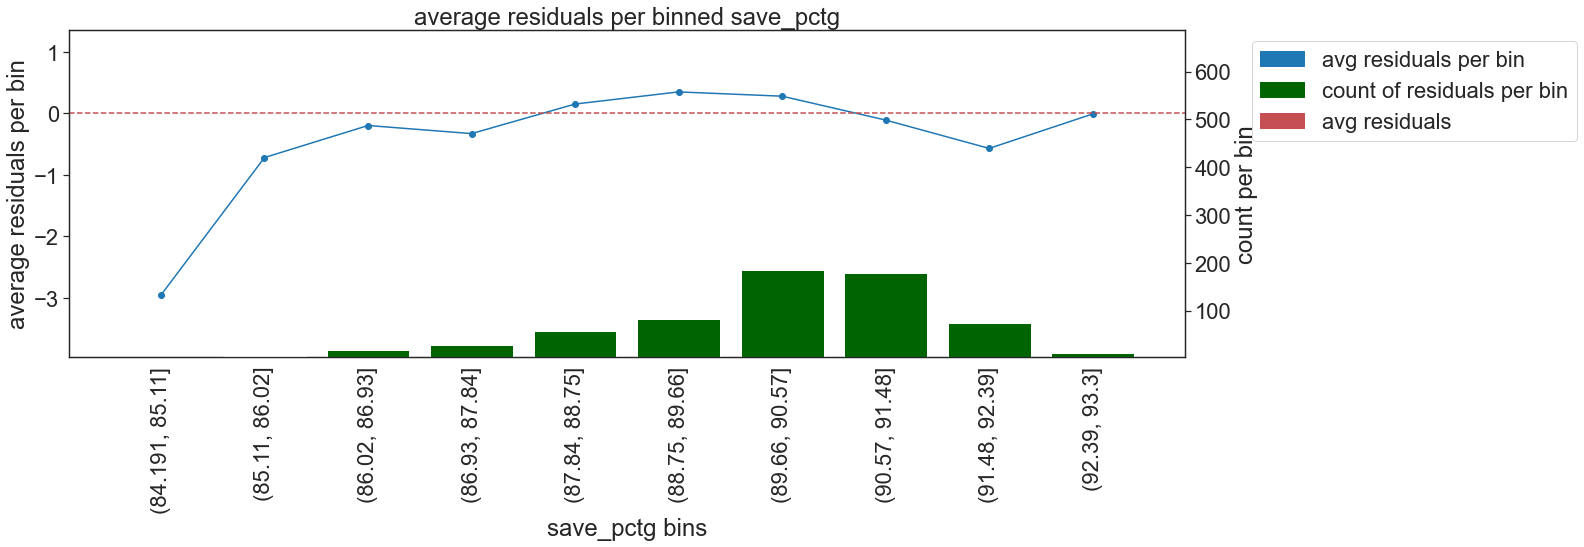

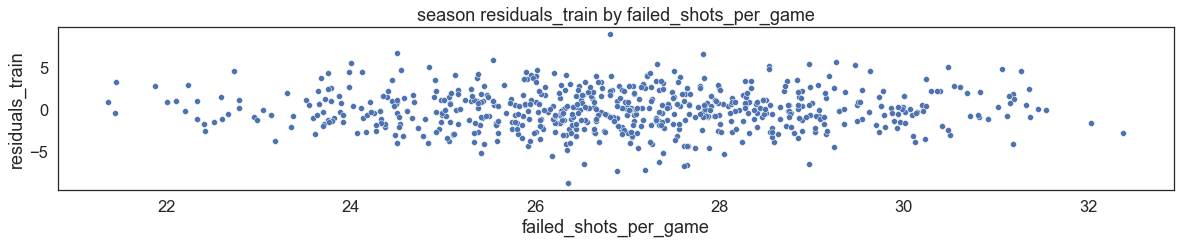

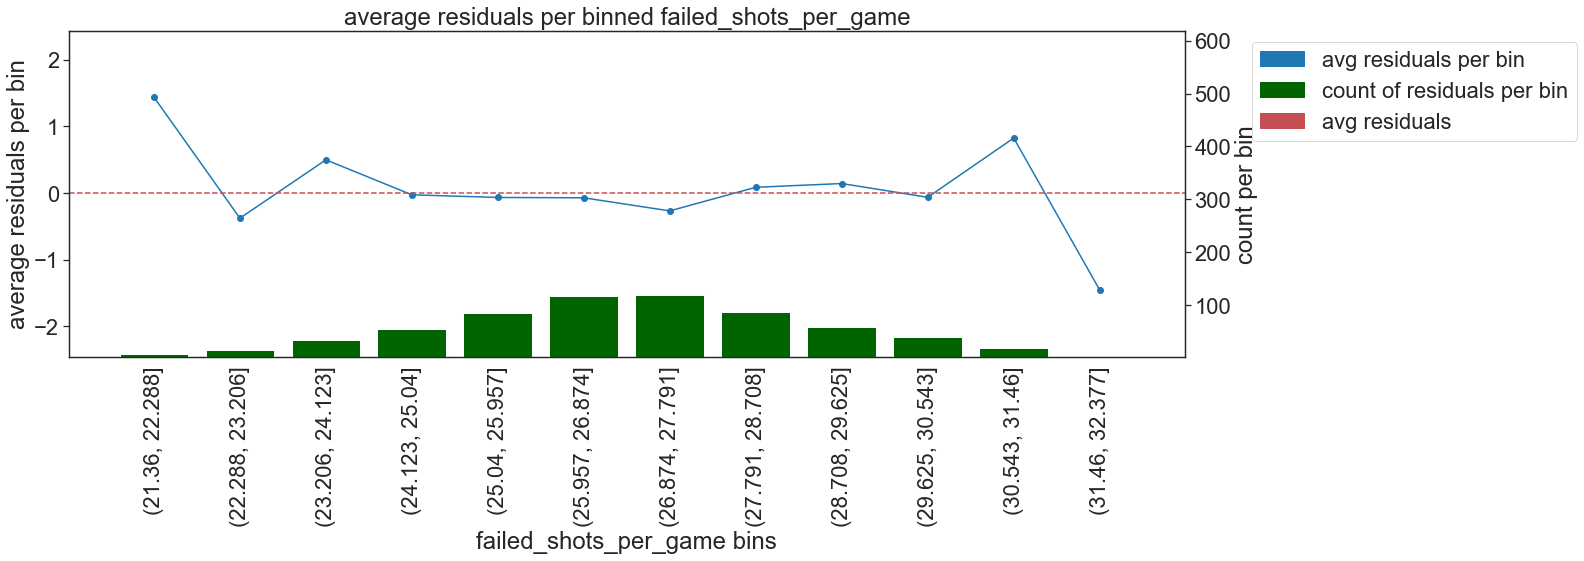

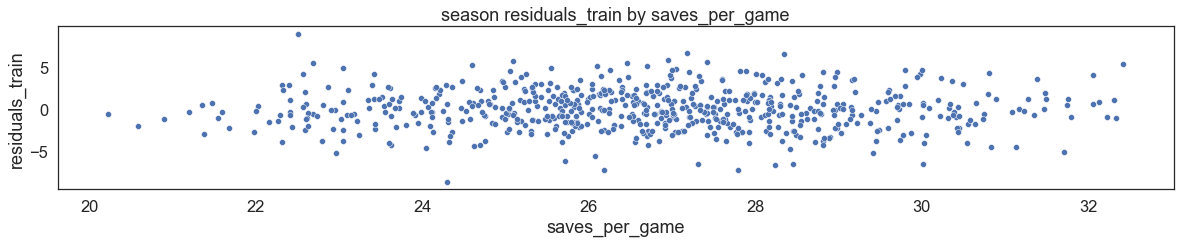

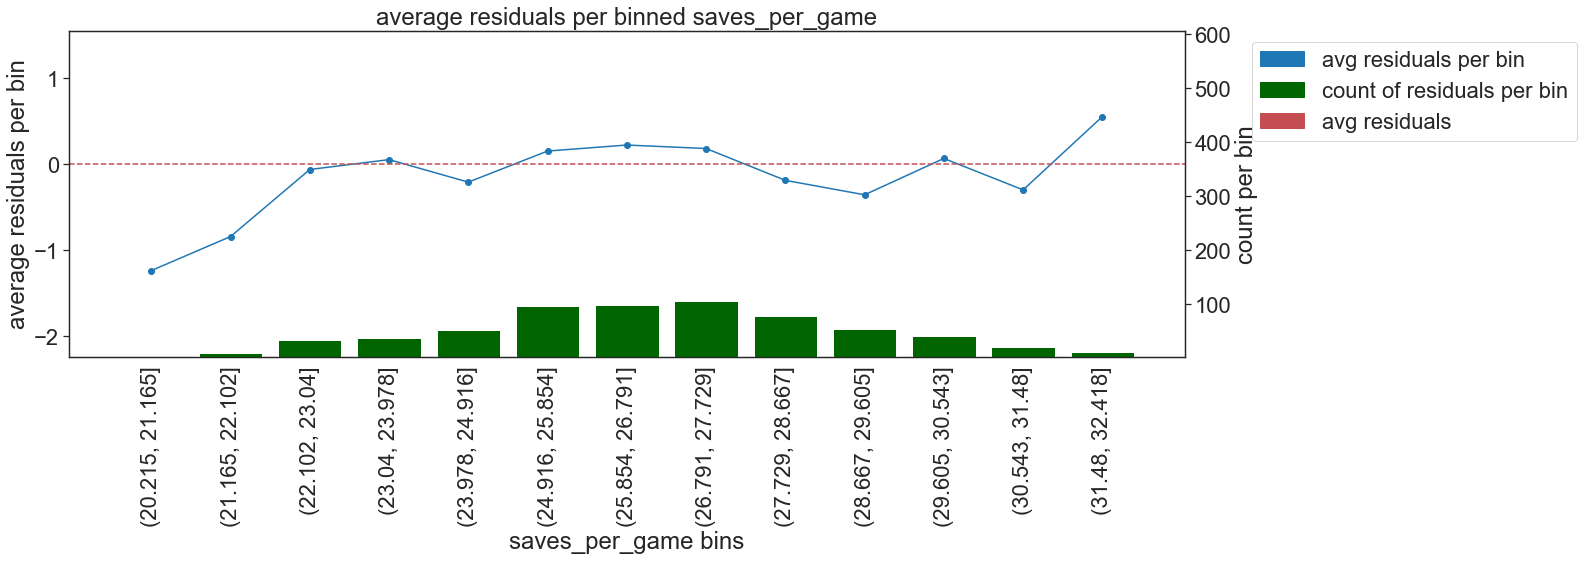

In [16]:
# residuals_train by all predictor variables plots
res_train_df = pd.concat([X_train_df, pred_train_df], axis = 1)
X_train_col = X_train_df.columns

for X in X_train_col:
    
    target_univariate_scatter(
        df = res_train_df, 
        x = X, 
        y = 'residuals_train', 
        length = 3, 
        width = 20, 
        font = 1.5
    )
    
    residual_means_counts_plot(
        df = res_train_df,
        X = X, 
        res = 'residuals_train',
        ymin1 = -1, 
        ymax1 = 1, 
        ymin2 = 0, 
        ymax2 = 500, 
        font = 2, 
        length = 6,
        width = 20
    )

Again, there appears to be some variance in the residual errors per feature while errors appear to be small. This is more true on the high and low tail ends where sample is at its lowest.

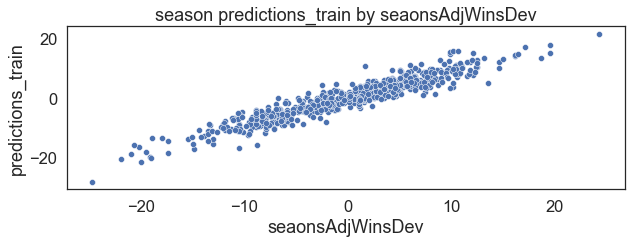

In [15]:
# Predicted seaonsAdjWinsDev results by actual seaonsAdjWinsDev for train data
target_univariate_scatter(
    df = pred_train_df,
    x = 'seaonsAdjWinsDev',
    y = 'predictions_train',
    length = 3, 
    width = 10, 
    font = 1.5
)

The model predictions are compared with the target variable (seaonsAdjWinsDev) and display good results due to the tight line, showing that the errors are relatively low. 

As seaonsAdjWinsDev increases or decreases, the predictions follow.

#### Model Testing, Evaluation, and Interpretation  

In [16]:
# Predict with X_test
y_pred_test = regressor.predict(X_test)
# Create data frame of predicted results
y_pred_test_df = pd.DataFrame(y_pred_test, columns = ['predictions_test']).reset_index()

# Create a single data frame with all prediction and actual y data for test data
y_test_df = pd.DataFrame(y_test, columns = ['seaonsAdjWinsDev']).reset_index()
pred_test_df = pd.merge(y_pred_test_df, y_test_df, on = 'index')
y_pred_test_df = y_pred_test_df.drop(['index'], axis = 1, errors = 'ignore')
y_test_df = y_test_df.drop(['index'], axis = 1, errors = 'ignore')
pred_test_df['residuals_test'] = pred_test_df['predictions_test'] - pred_test_df['seaonsAdjWinsDev']

print('\n')
pred_test_df.info()
pred_test_df.head()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 277 entries, 0 to 276
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             277 non-null    int64  
 1   predictions_test  277 non-null    float64
 2   seaonsAdjWinsDev  277 non-null    float64
 3   residuals_test    277 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 10.8 KB


,index,predictions_test,seaonsAdjWinsDev,residuals_test
0,0,1.046430,0.134615,0.911815
1,1,4.798277,3.571429,1.226848
2,2,-12.620601,-15.696429,3.075827
3,3,-4.950298,-3.346154,-1.604145
4,4,2.071621,5.053571,-2.981951


The above is a data frame focusing on the test model results.

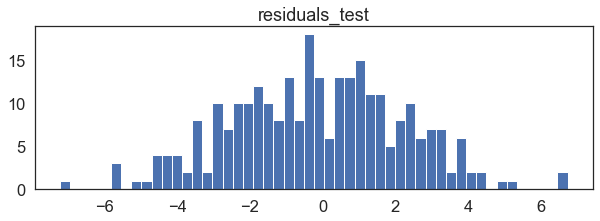


X continuous descriptive stats:


,count,mean,std,min,25%,50%,75%,max
residuals_test,277.0,-0.165533,2.371364,-7.20514,-1.870033,-0.173407,1.444524,6.73729



normality test:

statistic: 0.86
pvalue: 0.29



In [17]:
# residuals_test distribution
wins = pred_test_df[['residuals_test']]

num_univariate_histogram(
    df = wins, 
    length = 3, 
    width = 10, 
    rows = 1, 
    col = 1, 
    font = 1.5,
    kind = 2
)

print(
    '\n' + 'normality test:' +  '\n' + '\n' + 'statistic: ' + str(round(normaltest(wins.residuals_test.values)[1], 2)) +
    '\n' + 'pvalue: ' + str(round(normaltest(wins.residuals_test.values)[0],2)) + '\n'
)

The residuals are normally distributed, and the mean is 0, indicating that the errors are close to 0.

The distribution also displays that there are some outliers on the left tail existing roughly beyond -6 and 6.

The outliers show the models under and over-prediction of seaonsAdjWinsDev.

This is in line with the training results.

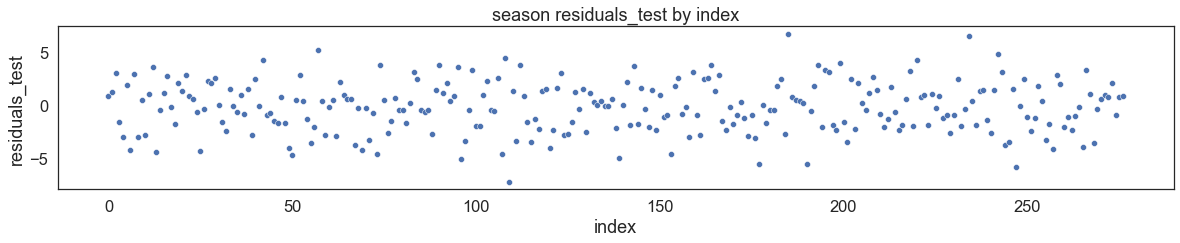

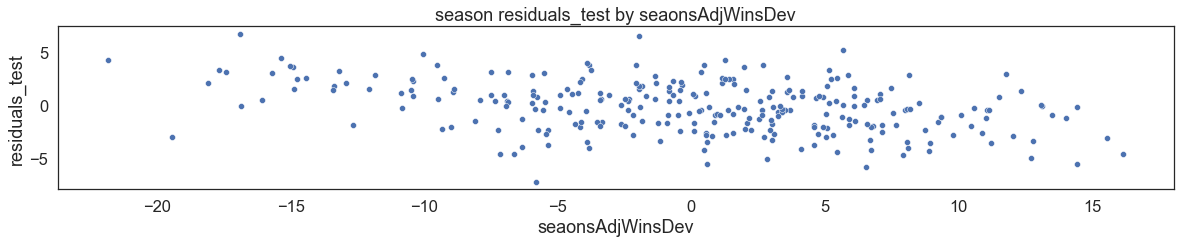

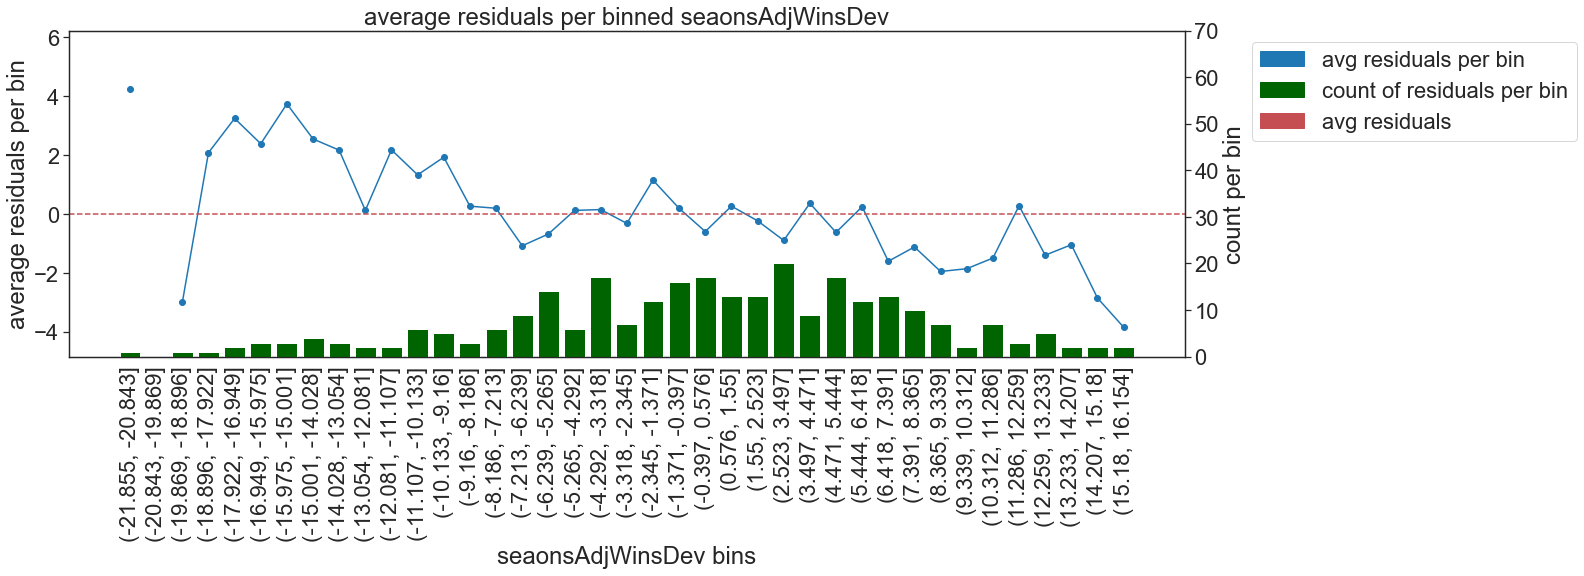

In [18]:
# residuals_test by index scatter plot
target_univariate_scatter(
    df = pred_test_df,
    x = 'index',
    y = 'residuals_test', 
    length = 3, 
    width = 20,
    font = 1.5
)

# residuals_test by seaonsAdjWinsDev scatter plot
target_univariate_scatter(
    df = pred_test_df,
    x = 'seaonsAdjWinsDev', 
    y = 'residuals_test', 
    length = 3, 
    width = 20, 
    font = 1.5
)

# Residual means and counts plot
residual_means_counts_plot(
    df = pred_test_df,
    X = 'seaonsAdjWinsDev', 
    res = 'residuals_test',
    ymin1 = -1, 
    ymax1 = 2, 
    ymin2 = 0,
    ymax2 = 50,
    font = 2,
    length = 6, 
    width = 20
)

The residuals appear to be similar but, as expected, not as consistent as the train data.

Overall, the residuals are not overwhelmingly high.

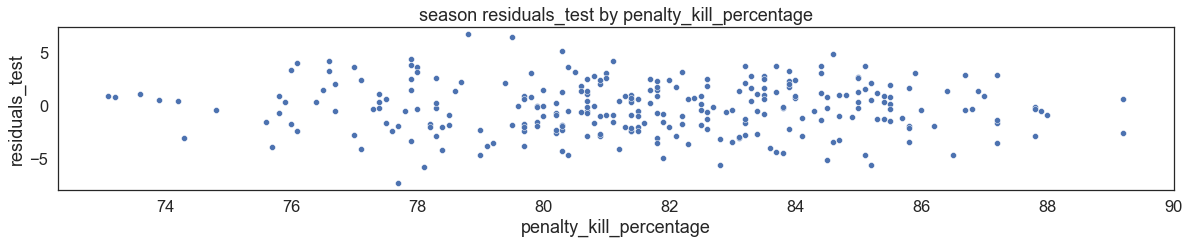

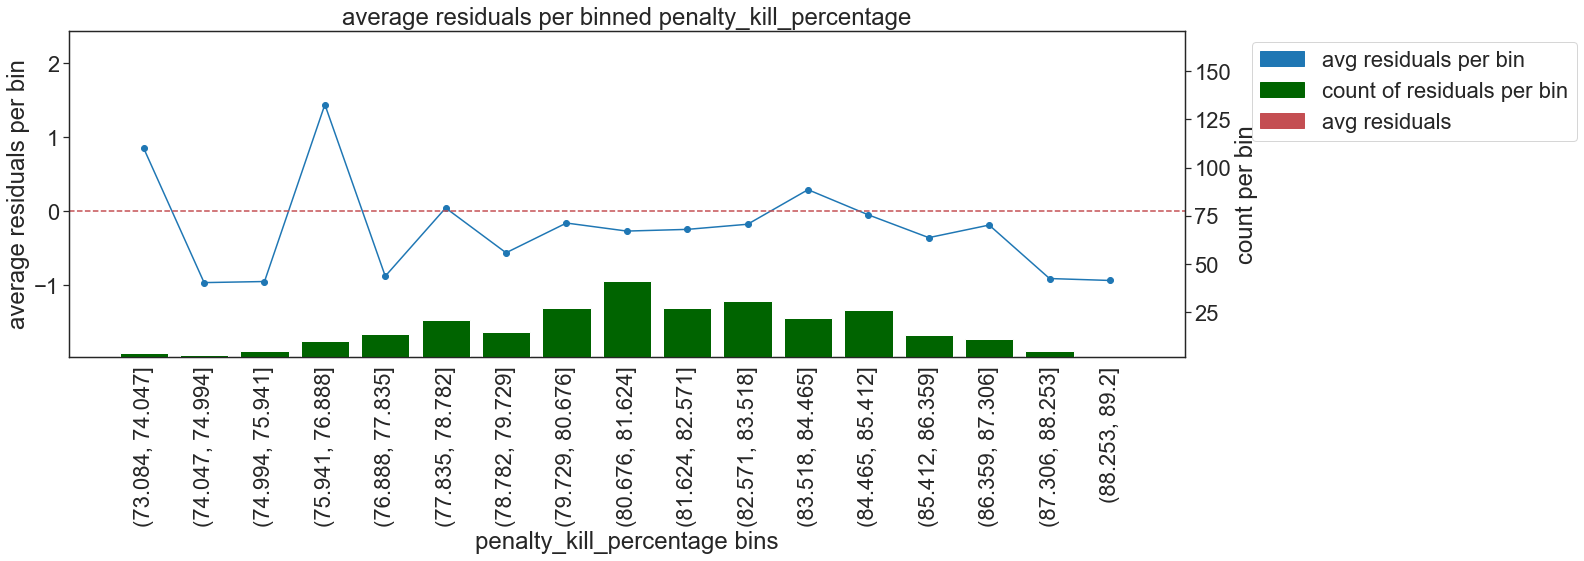

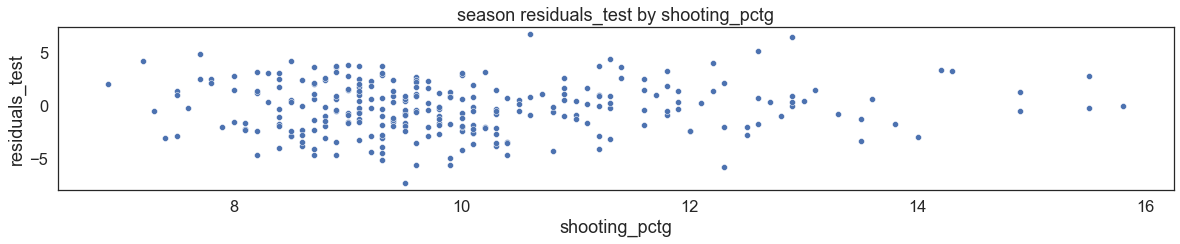

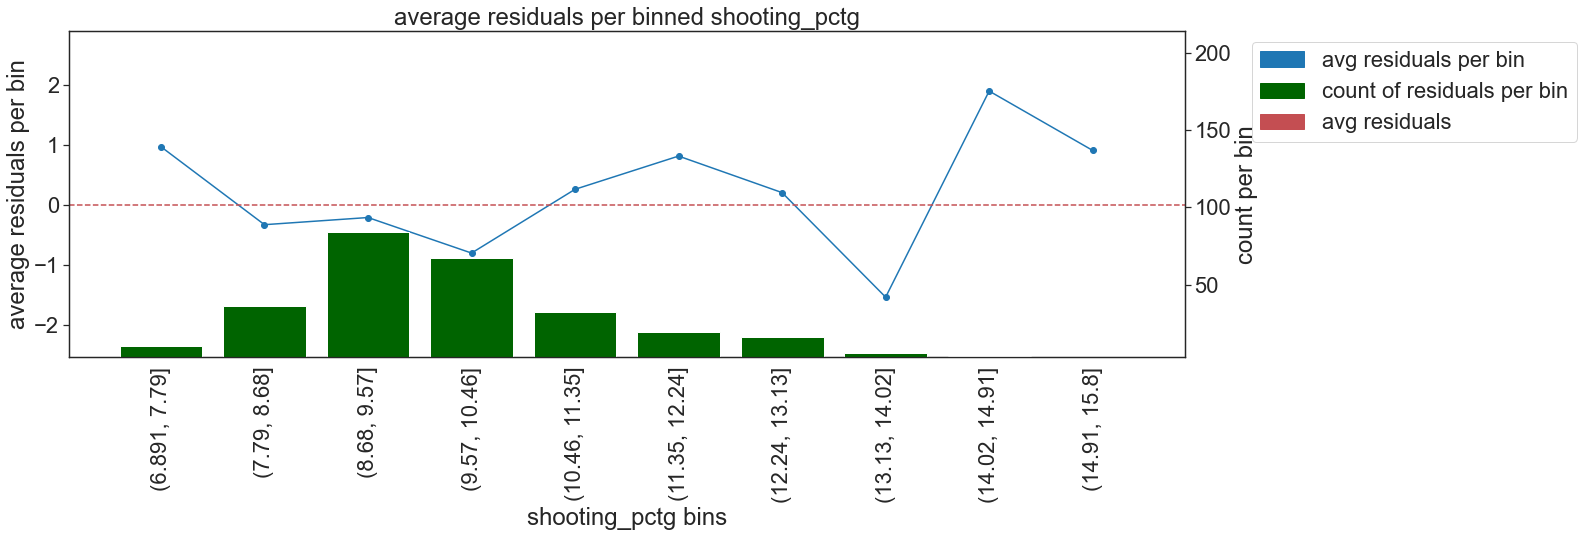

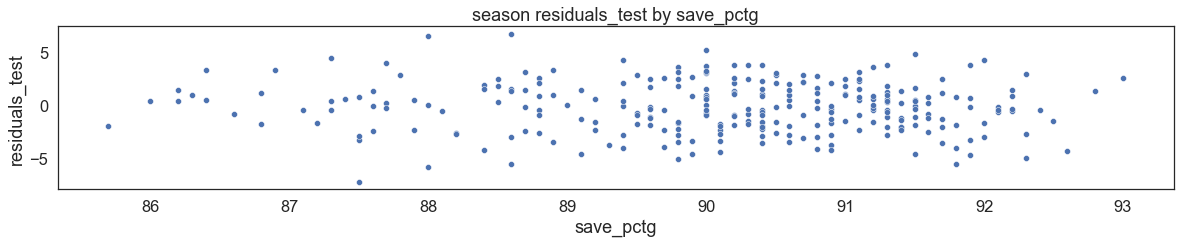

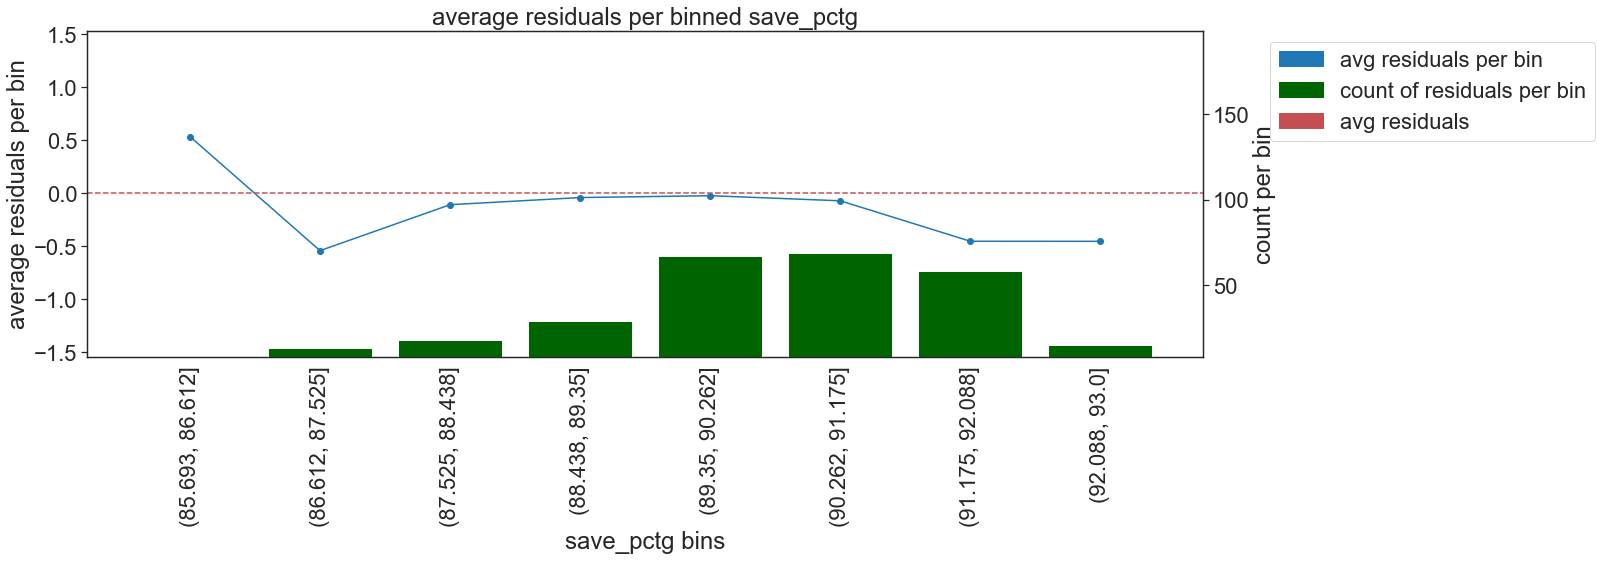

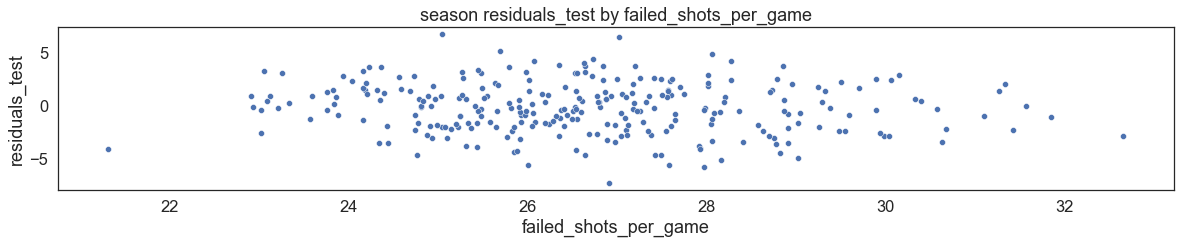

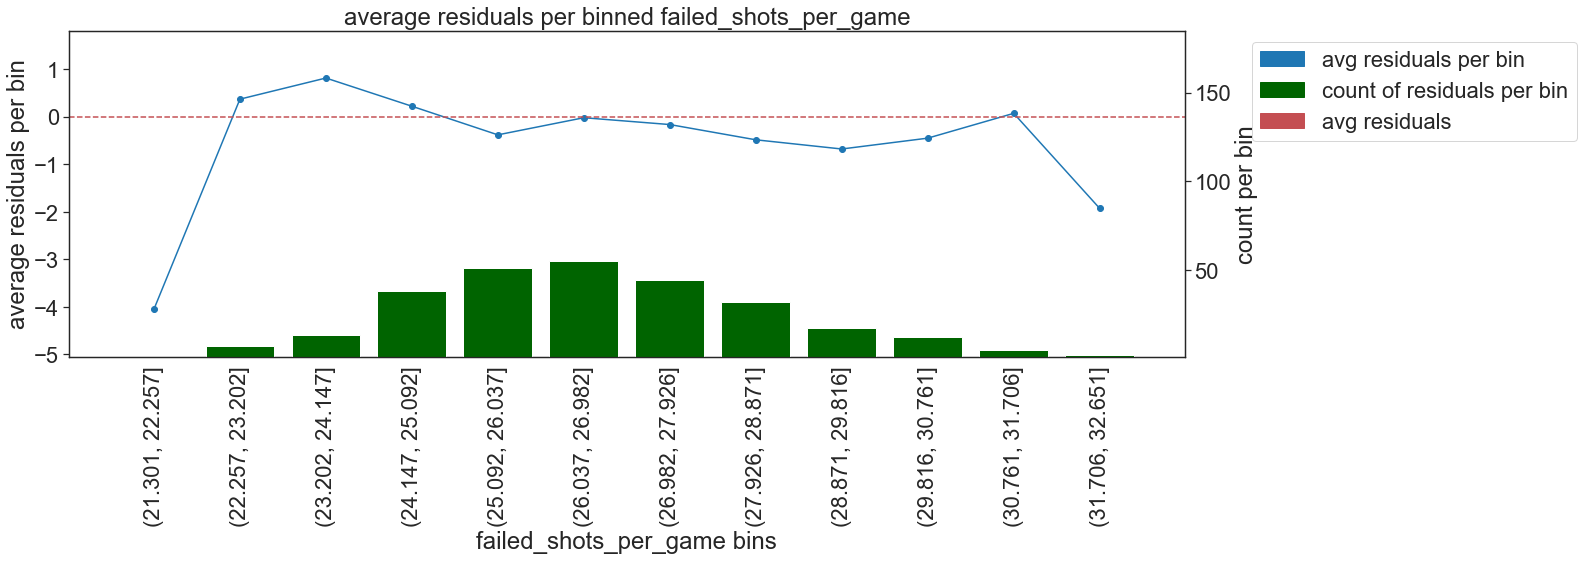

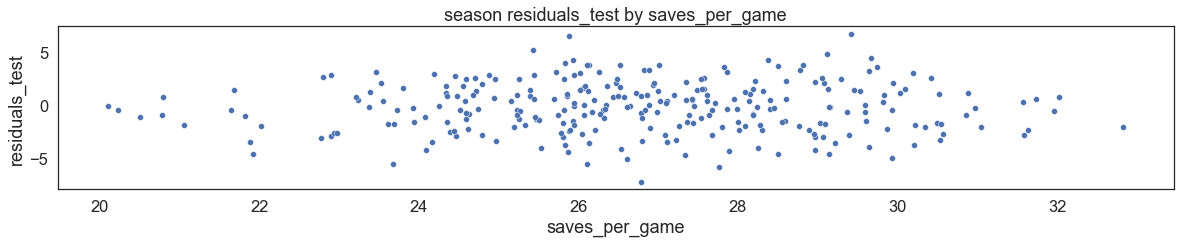

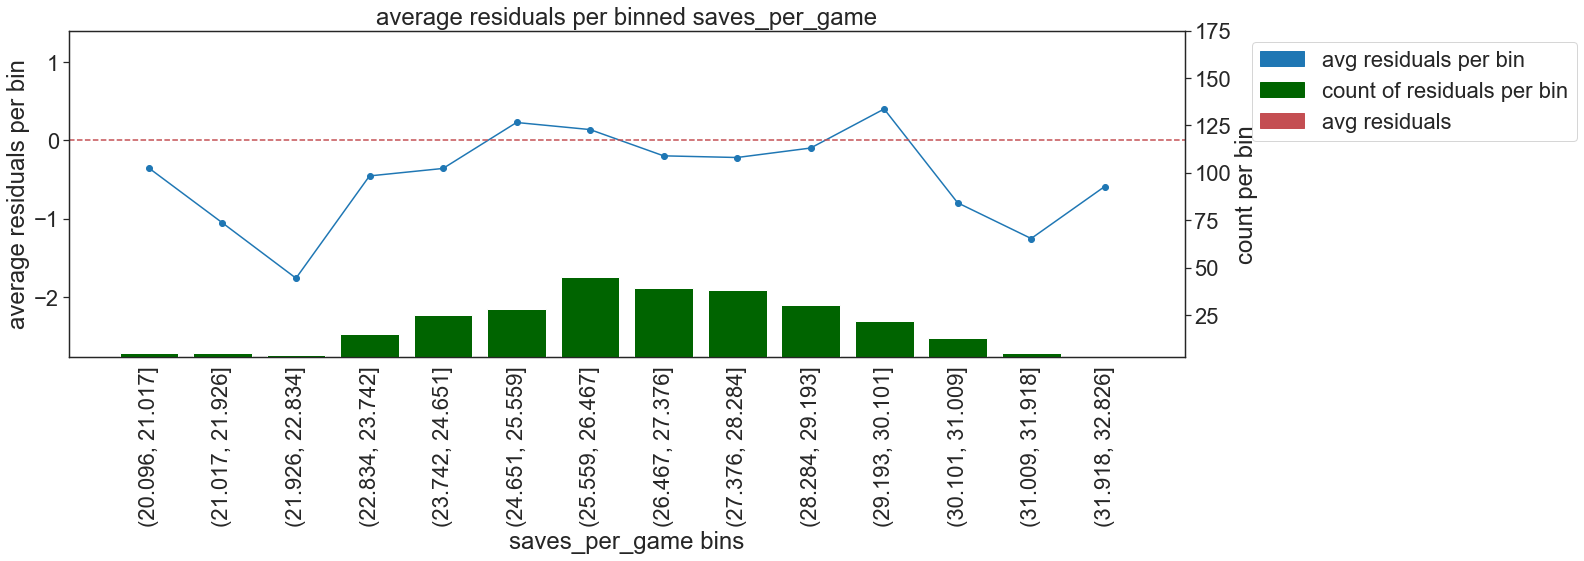

In [19]:
# residuals_test by all predictor variables plots
res_test_df = pd.concat([X_test_df, pred_test_df], axis = 1)
X_test_col = X_test_df.columns

for X in X_test_col:
    
    target_univariate_scatter(
        df = res_test_df,
        x = X,
        y = 'residuals_test',
        length = 3, 
        width = 20, 
        font = 1.5
    )
    
    residual_means_counts_plot(
        df = res_test_df, 
        X = X, 
        res = 'residuals_test',
        ymin1 = -1, 
        ymax1 = 1, 
        ymin2 = 0, 
        ymax2 = 130, 
        font = 2, 
        length = 6, 
        width = 20
    )

Again, as expected, the variance of the residual errors per feature are larger.

Overall, the residuals are not overwhelmingly high.

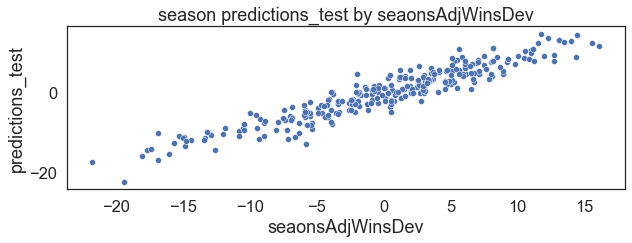

In [20]:
# Regression result metrics and summary for train data
target_univariate_scatter(
    df = pred_test_df,
    x = 'seaonsAdjWinsDev', 
    y = 'predictions_test', 
    length = 3,
    width = 10, 
    font = 1.5
)

The predicted values by seaonsAdjWinsDev line appears to be relatively tight but slightly less than the train data as expected.

In [21]:
# Regression evaluation metrics and summary for test data
regression_test_metrics(y = y_test_df, y_pred = y_pred_test_df)


model metrics:

r-squared:                          .................0.9
mean absolute error:                ................1.92
mean squared error:                 ................5.63
root Mean squared error:            ................2.37


The model shows strong results when run on the test data. The over all metrics either stayed the same (r-squared & RMSE) or slightly increased (MAE & MSE).

### Model Finalization

#### Model Finalizing, Evaluation, and Interpretation  

In [22]:
# Finalize model with full rescaled data set
# Get X values
X = nhl_df.copy()
X = X[X_train_df.columns]

# Get y values
y = nhl_df.copy()
y = y[y_train_df.columns]

# Print data results
print(X.info())
display(X.head())
print(y.info())
display(y.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   penalty_kill_percentage  922 non-null    float64
 1   shooting_pctg            922 non-null    float64
 2   save_pctg                922 non-null    float64
 3   failed_shots_per_game    922 non-null    float64
 4   saves_per_game           922 non-null    float64
dtypes: float64(5)
memory usage: 36.1 KB
None


,penalty_kill_percentage,shooting_pctg,save_pctg,failed_shots_per_game,saves_per_game
0,75.3,10.9,86.3,23.511263,27.616000
1,81.5,14.7,89.9,25.824575,30.015362
2,78.1,12.3,88.0,27.965338,27.764000
3,76.6,11.9,87.3,32.376750,25.011450
4,76.0,11.2,86.6,25.163700,31.479100


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922 entries, 0 to 921
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seaonsAdjWinsDev  922 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB
None


,seaonsAdjWinsDev
0,-19.470588
1,12.029412
2,6.529412
3,9.029412
4,-20.970588


In [23]:
# Fit and train the logistic regression model
regressor = LinearRegression()

# Scale X values (converts X values to numpy 2D array)
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Convert y values to numpy 1D array
y = y.iloc[:,:].values
y = y.reshape((-1,))

# Fit regressor
regressor.fit(X, y)

LinearRegression()

The above block of code finalizes that model by training on all data available (scaled train and test data).

In [24]:
# Save the model
dump(regressor, open('Regression_Models/NHL_Season_Wins_Linear_Regression_Model.pkl', 'wb'))

# save the scaler
dump(scaler, open('Regression_Models/Scaler_Lin.pkl', 'wb'))

Save the regression model.

In [25]:
# load the model
regressor = load(open('Regression_Models/NHL_Season_Wins_Linear_Regression_Model.pkl', 'rb'))

# load the scaler
scaler = load(open('Regression_Models/Scaler_Lin.pkl', 'rb'))

Load the regression model.

Residuals:
    Min      1Q  Median     3Q    Max
-8.6555 -1.5782 -0.0434 1.5088 9.0291


Coefficients:
                         Estimate  Std. Error  t value   p value
_intercept              -0.000000    0.077665  -0.0000  1.000000
penalty_kill_percentage -0.270124    0.101357  -2.6651  0.007832
shooting_pctg            6.336255    0.090100  70.3247  0.000000
save_pctg                6.440228    0.108858  59.1617  0.000000
failed_shots_per_game    2.844634    0.078777  36.1101  0.000000
saves_per_game          -3.389735    0.087099 -38.9183  0.000000
---
R-squared:  0.89648,    Adjusted R-squared:  0.89592
F-statistic: 1586.54 on 5 features


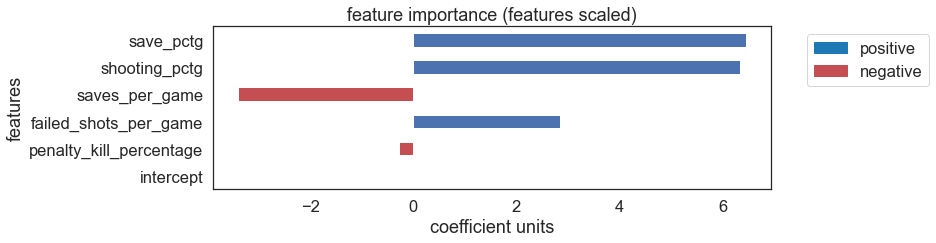

,features,coef,positive
5,save_pctg,6.440228e+00,True
4,shooting_pctg,6.336255e+00,True
3,saves_per_game,-3.389735e+00,False
2,failed_shots_per_game,2.844634e+00,True
1,penalty_kill_percentage,-2.701241e-01,False
0,intercept,-1.924487e-14,False


In [26]:
# Regressor Summary
Xlabels = X_train_df.columns
stat.summary(regressor, X, y, Xlabels)

# Convert X to data frame
X = pd.DataFrame(X, columns = X_train_df.columns)

# Feature improtance bar chart
regression_feature_importance(
    model = regressor,
    X_cols = X, 
    font = 1.5,
    length = 3, 
    width = 10,
    pos = 'b',
    neg = 'r'
)

Above, we can see which features have the most significant impact on seaonsAdjWinsDev per unit increase on a scaled basis.

NHL organizations can use this information to prioritize when strategizing or building their teams.

So we now know shootingPctg, savePctg, savesPerGame, failedShotsPerGame, and penaltyKillPercentage significantly impact the positive or negative deviations of adjusted games won. We can now go a step farther and see how these deviations relate to making the playoffs. 

These variables seem like a "given" and very "high-level"; however, if positive adjusted wins have a strong relationship with making the playoffs, they can be used as high-level KPIs for organizations to reach for during the building and development of their teams.

This would include getting more granular data to help predict the variance in the new KPIs:  shootingPctg, savePctg, savesPerGame, failedShotsPerGame, and penaltyKillPercentage. E.g., blocked shots, location of shots, line match-ups, team strategies and outcomes, etc.